# Business Problem

Earthquakes happen unexpectedly and sometimes, violently. We normally don't think about it in our daily lives, but we always do after the destruction. There are laws to help mitigate the damage of earthquakes, especially in areas with many titonic plates, but now we can take action to mitigate those damages before hand, through the power of data

(Some) government wants to find out how to minimalize destruction. Using data collected from the Nepal Earthquake in 2015, build a predictive model to correctly classify how much damage a building will have based on its characteristics.

From there, identify common features with buildings that were "destruction_grade 3" to the fix common issues 

### Chosen Metric: F1_Score - Micro

Because we are building a predictor for potentially remodeling some buildings, having false positives will be extremely expensive, and we definately do not want to miss false negatives as that could potentionally put lives at risk. F1_scores is a metric that is a combination of recall and precision.

We also found some class imbalance in our target variable, f1_micro is one of the best metrics to deal with class imbalance issues.

Because of these two factors, f1_micro is the metric we will be using to judge our model.

## Data Understanding

### Imports

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix


#### Loading The Data

In [3]:
df_values = pd.read_csv('data/train_values.csv', index_col = 'building_id')
df_labels = pd.read_csv('data/train_labels.csv', index_col = 'building_id')

In [48]:
df_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

In [49]:
df_labels.head()

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


In [50]:
df_labels['damage_grade'].value_counts(normalize = True)

2    0.568912
3    0.334680
1    0.096408
Name: damage_grade, dtype: float64

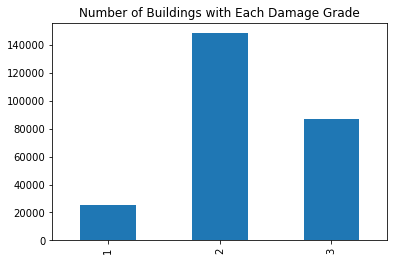

In [51]:
(df_labels.damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of Buildings with Each Damage Grade"));

### Since the use of the building has no effect on the damage caused by earthquakes, we dropped unrelevant columns

In [4]:
# This reduced our dataset by almost 33%!
selected_features = df_values.columns[:25]
features_list = []

for feature in selected_features:
    features_list.append(feature)
    
train_values_subset = df_values[features_list]

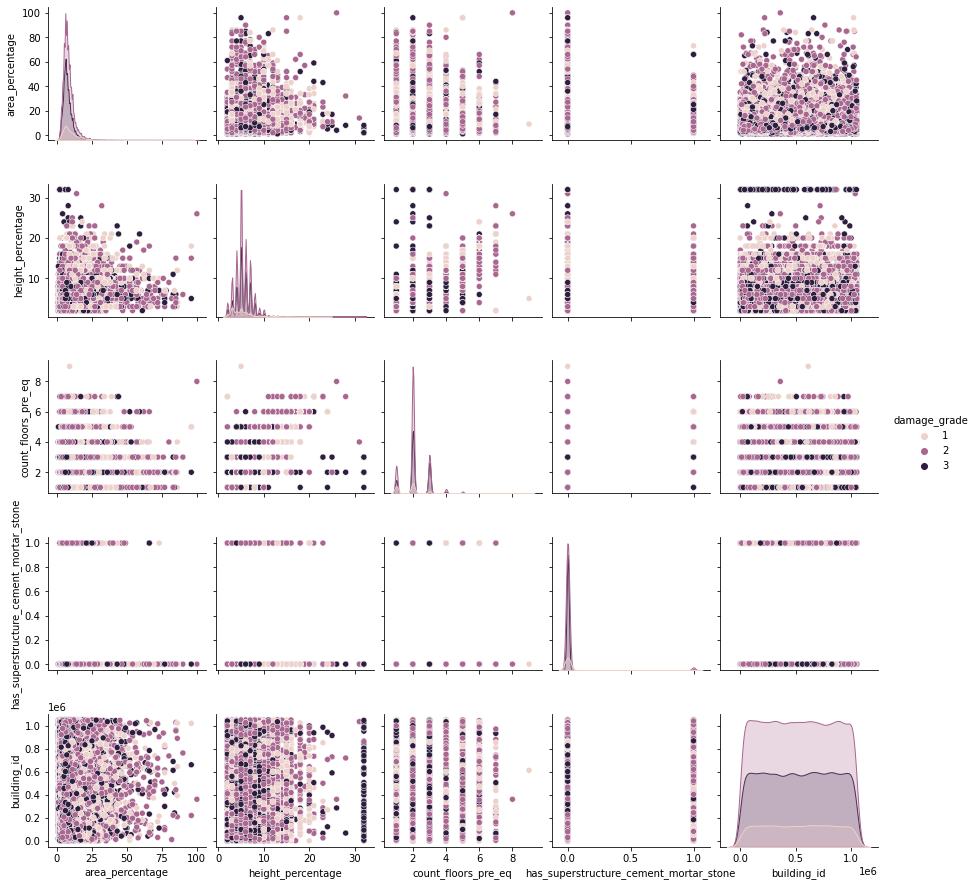

In [25]:
# Pairplot of our selected features plotted by each damage grade
sns.pairplot(train_values_subset.join(df_labels), 
             hue='damage_grade')

## Data Preparation

We split the data into train-test splits here so we can easily pass them straight into the models for testing later.

In [6]:
# Create our train_test split
X_train, X_test, y_train, y_test = train_test_split(train_values_subset, df_labels)

Since this data was provided to us by a competition on DrivenData on creating the best predictor, they had already cleaned the data for us, so all we have to do is transform the data so our model will be able to read it.

For that, we decided to use sklearn's OneHotEncoder class.

In [7]:
encoder = OneHotEncoder(handle_unknown = 'ignore')
encoder.fit(X_train)

OneHotEncoder(handle_unknown='ignore')

In [8]:
# Get dummy variables for our object columns for modeling
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

# Random Forest Classifer

In [13]:
# Create a pipeline to find best parameters
# Pass in 'with_mean = False' because OneHotEncoder transformed our X_train into a sparse matrix
pipe = make_pipeline(StandardScaler(with_mean = False), 
                     RandomForestClassifier(random_state=2018))
pipe

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=2018))])

In [14]:
# Test various parameters with grid_search and cross validate the data
param_grid = {'randomforestclassifier__n_estimators': [100, 150],
              'randomforestclassifier__min_samples_leaf': [5, 10]}
gs = GridSearchCV(pipe, param_grid, cv=5)

In [15]:
# Fit the estimator
gs.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=2018))]),
             param_grid={'randomforestclassifier__min_samples_leaf': [5, 10],
                         'randomforestclassifier__n_estimators': [100, 150]})

In [18]:
# Print our best paramters
gs.best_params_

{'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 150}

In [16]:
# Print our the cross validation test scores
gs.cv_results_['mean_test_score']

array([0.70012791, 0.70013814, 0.68183167, 0.68204656])

In [17]:
# Test for F1 score
y_pred = gs.predict(X_test)
f1_score(y_test, y_pred, average = 'micro')

0.7063744224954337

# KNN

# Naive Bayes